## Train classifier by layers

This notebook trains a classifier that operates in two layers:
- First we use a SVM classifier to label utterances with high degree of certainty.
- Afterwards we use heuristics to complete the labeling

### Import and path definition

In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

root_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_path = os.path.join(root_path,'data')
tables_path = os.path.join(data_path,'tables')

### Load data

In [2]:
WITH_STEMMING = True
#REMOVE_STOPWORDS = True
SEED = 10
NUM_TOPICS = 60
random.seed(SEED)

In [3]:
file_name = '[train]IBL_topic_distribution_by_utterance_with_co_occurrence_time_utterance_minimum_0_words_with_stemming_{}_{}.xlsx'.format(WITH_STEMMING,NUM_TOPICS)
df_data = pd.read_excel(os.path.join(tables_path,'train',file_name))

In [4]:
df_data.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 60-Topic 59,phase,phase_1,phase_2,phase_3,phase_4,phase_5,utterance,length utterance,utterance_relative_time
0,0.009546,0.012683,0.006349,0.005774,0.003684,0.005008,0.004698,0.008680,0.012694,0.015815,...,0.000142,1,1,0,0,0,0,SATUNNAINEN,0.000000,0.000000
1,0.006810,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009057,0.011282,...,0.000072,1,1,0,0,0,0,siel QUESTION_SYMBOL onks oo palo,0.065574,0.010417
2,0.102352,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009055,0.011302,...,0.000072,1,1,0,0,0,0,no tää varm muutu,0.049180,0.017361
3,0.005717,0.007596,0.003803,0.077291,0.002207,0.003000,0.002814,0.005199,0.007603,0.009472,...,0.000051,1,1,0,0,0,0,aja T_ ATOMI ehtiny törm ton ver,0.098361,0.020833
4,0.111645,0.004865,0.002435,0.002215,0.001413,0.001921,0.001802,0.003329,0.004869,0.006066,...,0.000021,1,1,0,0,0,0,ton ver ai pitä muute kato sil taas oo lask to...,0.213115,0.027778


### split data

In [5]:
the_keys = list(set(df_data['phase']))
total_samples = 0
class_samples = {}
for key in the_keys:
    n = list(df_data.phase.values).count(key)
    #print("key {}, total {}".format(key,n))
    total_samples += n
    class_samples[key] = n
print(total_samples)
for key in the_keys:
    print("key {}, samples: {}, prop: {}".format(key,class_samples[key],round(class_samples[key]*1.0/total_samples,2)))

1600
key 1, samples: 403, prop: 0.25
key 2, samples: 175, prop: 0.11
key 3, samples: 406, prop: 0.25
key 4, samples: 62, prop: 0.04
key 5, samples: 554, prop: 0.35


In [6]:
def split_df(df,val_set_threshold):
    train_set = {}
    validation_set = {}
    for name, group in df_data.groupby(['phase']):
        train_set[name]=[]
        validation_set[name]=[]
        n = len(group)
        ra = random.sample(range(n),int(n*val_set_threshold))
        print("validation set phase {}: {}".format(name,int(n*val_set_threshold)))
        count = 0
        group = group.reset_index()
        for i,row in group.iterrows():
            if i in ra:
                count+=1
                validation_set[name].append(row.values)
            else:
                train_set[name].append(row.values)
    return train_set,validation_set

In [7]:
filter_rows = list(range(1,1801))+[1808,1809]
filter_labels = [1801]

In [8]:
def get_data_from_dict(a_dict):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            y.append(key)
    return X,y

In [9]:
train_set,validation_set = split_df(df_data,0.2)
X_train,y_train = get_data_from_dict(train_set)
X_val,y_val = get_data_from_dict(validation_set)

validation set phase 1: 80
validation set phase 2: 35
validation set phase 3: 81
validation set phase 4: 12
validation set phase 5: 110


In [10]:
all_set,_ = split_df(df_data,0.0)
X_all,y_all = get_data_from_dict(all_set)

validation set phase 1: 0
validation set phase 2: 0
validation set phase 3: 0
validation set phase 4: 0
validation set phase 5: 0


### Classify first layer

In [11]:
class_weight = {}
for key in the_keys:
    class_weight[key] = 1000.0/class_samples[key]

In [12]:
class_weight[1] = 3

In [13]:
svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True,class_weight=class_weight)#
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_val, y_val)))

Accuracy of SVM classifier on training set: 0.37
Accuracy of SVM classifier on test set: 0.37


In [14]:
pred = svc.predict(X_val)
labels = ["Phase {}".format(i) for i in range(1,6)]
df = pd.DataFrame(confusion_matrix(y_val, pred),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
#print(" ")
print(classification_report(y_val, pred))
df

              precision    recall  f1-score   support

           1       0.30      0.80      0.44        80
           2       0.35      0.23      0.28        35
           3       0.66      0.33      0.44        81
           4       0.33      0.25      0.29        12
           5       0.49      0.15      0.23       110

   micro avg       0.37      0.37      0.37       318
   macro avg       0.43      0.35      0.34       318
weighted avg       0.46      0.37      0.35       318



,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,64,5,4,0,7
Phase 2,18,8,2,3,4
Phase 3,46,1,27,0,7
Phase 4,8,1,0,3,0
Phase 5,74,8,8,3,17


### Find threshold

Look for the distance to the second max

In [15]:
pred_val = svc.predict_proba(X_val)
prob_pred = [v[int(y_val[i]-1)] for i,v in enumerate(pred_val)]

(array([32., 44., 80., 91., 40., 10., 13.,  3.,  3.,  2.]),
 array([0.03063697, 0.1213367 , 0.21203644, 0.30273617, 0.39343591,
        0.48413565, 0.57483538, 0.66553512, 0.75623485, 0.84693459,
        0.93763433]),
 <a list of 10 Patch objects>)

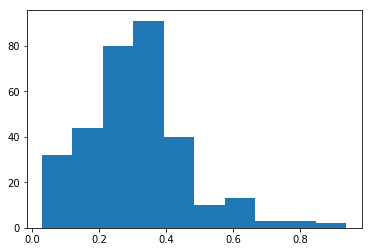

In [16]:
plt.hist(prob_pred)

In [17]:
tuple_winner_pred = [(np.max(v),prob_pred[i],np.max(v)==prob_pred[i]) for i,v in enumerate(pred_val)]
values_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==True]
values_not_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==False]
values_dist_not_ok = [v[0]-v[1] for i,v in enumerate(tuple_winner_pred) if v[2]==False]

In [18]:
len(X_all[0])

1802

(array([ 0.,  2., 43., 70., 40., 13.,  4.,  4.,  3.,  2.,  0.,  0.,  1.,
         0.]),
 array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
        0.75, 0.8 , 0.85, 0.9 ]),
 <a list of 14 Patch objects>)

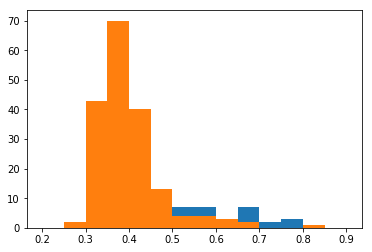

In [19]:
plt.hist(values_ok,np.arange(0.2,.95,.05))
plt.hist(values_not_ok,np.arange(0.2,.95,.05))

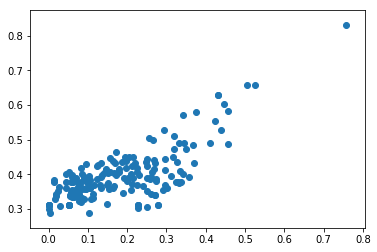

In [20]:
plt.scatter(values_dist_not_ok,values_not_ok)

Define Threshold 

In [21]:
t = 0.5

In [22]:
def first_layer_classifier(features,threshold):
    pred_val = svc.predict_proba(features)
    #n_classes = len(svc.class_weight_)
    pred_labels = []
    for val in pred_val:
        if np.max(val) > threshold:
            pred_labels.append(np.argmax(val)+1)
        else:
            pred_labels.append(-1)
    return pred_labels

In [23]:
output_first_layer = first_layer_classifier(X_all,t)
comparison = list(zip(output_first_layer,y_all))

In [24]:
df_data['first_layer'] = output_first_layer

In [25]:
#df_data.to_excel(os.path.join(tables_path,'[first_layer]'+file_name))

### Second layer

In [26]:
pred_val = svc.predict_proba([X_all[3]])
pred_val

array([[0.21624826, 0.2311034 , 0.13639123, 0.04128113, 0.37497598]])

In [27]:
def find_closest_phase(index,phases,backwards=True):
    if phases[index] != -1:
        raise ValueError("Phase[index] is not -1")
    if backwards:
        for i in range(index-1,-1,-1):
            if phases[i] != -1:
                return phases[i]
    else:
        for i in range(index+1,len(phases)):
            if phases[i] != -1:
                return phases[i]
    return -1

In [28]:
def second_layer_classifier_max_border(features,df):
    second_layer = []
    phases = df.first_layer.values
    error = 0
    for i,row in df.iterrows():
        if row.first_layer != -1:
            second_layer.append(row.first_layer)
        else:
            last_phase = find_closest_phase(i,phases,backwards=True)
            next_phase = find_closest_phase(i,phases,backwards=False)
            if next_phase == -1:
                error+= 1
            pred_val_i = svc.predict_proba([features[i]])[0]
            if pred_val_i[last_phase-1] > pred_val_i[next_phase-1]:
                second_layer.append(last_phase)
            else:
                second_layer.append(next_phase)
    print("Still no info: {}".format(error))
    return second_layer

In [29]:
second_layer = second_layer_classifier_max_border(X_all,df_data)

Still no info: 1


In [30]:
df_data['second_layer'] = second_layer
df_data.to_excel(os.path.join(tables_path,'[second_layer]'+file_name))

In [31]:
second_aux = []
y_all_aux = []
for i,e in enumerate(second_layer):
    if e!=-1:
        second_aux.append(second_layer[i])
        y_all_aux.append(y_all[i])
confusion_matrix(y_all_aux, second_aux)

array([[  0,   0, 134,   0, 269],
       [  0,  21,  15,   0, 139],
       [  0,   0, 308,   0,  98],
       [  0,   0,  58,   0,   4],
       [  0,   2,  84,   0, 468]], dtype=int64)

In [32]:
labels = ["Phase {}".format(i) for i in range(1,6)]
df = pd.DataFrame(confusion_matrix(y_all_aux, second_aux),columns=["Predicted {}".format(i) for i in labels])
df.index = labels